#Лабораторная работа 2
##Распределённые вычисления

**Задание 1:** Нахождение множества Мандельброта с использованием OpenMP  

**Выполнили:** Парфенцева Олеся и Шкулева Мария

**Здесь есть:** Отчёт и код, использовала колаб по Вашему совету :)

**Аппаратная платформа:** Google Colab, Linux, семейство x86-64, количество доступных вычислительных ядер можкт изменяться
в зависимости от нагрузки сервиса, использовался g++ с поддержкой OpenMP (-fopenmp).

## Задача
Требуется реализовать параллельную программу для нахождения множества
Мандельброта с использованием технологии OpenMP.

Точка c принадлежит множеству Мандельброта, если последовательность

z_{n+1} = (z_n)^2 + c,  z_0 = 0

остается ограниченной, то есть |z_n| < 2 для всех n.

Вычисления для каждой точки комплексной плоскости являются независимыми друг от друга.
Это позволяет распараллелить внешний цикл перебора точек.

Для параллелизации используется директива OpenMP `#pragma omp parallel for`.
Количество потоков и точек задаём через аргументы командной строки. Выводом является csv файл с координатами точек, подпадающих под множество Мандельброта.

In [1]:
!apt-get update
!apt-get install -y gcc g++ libomp-dev

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,556 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,856 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,633 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,966 kB]
Get:14 http://securit

In [10]:
%%writefile mandelbrot.cpp
#include <iostream>
#include <vector>
#include <complex>
#include <fstream>
#include <omp.h>
#include <algorithm>

using namespace std;

//Проверка принадлежности точки множеству Мандельброта
bool inMandelbrot(const complex<double>& c, int max_iter = 1000) {
    complex<double> z = 0.0;
    for (int i = 0; i < max_iter; ++i) {
        z = z * z + c;
        if (norm(z) > 4.0) {
            return false;
        }
    }
    return true;
}

int main(int argc, char* argv[]) {
    if (argc < 3) {
        cerr << "Usage: " << argv[0] << " nthreads npoints\n";
        return 1;
    }

    int nthreads = atoi(argv[1]);
    int npoints  = atoi(argv[2]);

    omp_set_num_threads(nthreads);

    double x_min = -2.0, x_max = 1.0;
    double y_min = -1.5, y_max = 1.5;

    int width  = static_cast<int>(sqrt(npoints));
    int height = width;

    double dx = (x_max - x_min) / width;
    double dy = (y_max - y_min) / height;

    vector<pair<double, double>> results;

    //Замеры времени
    double best_time = 1e9;

    for (int run = 0; run < 5; ++run) {

        results.clear();
        double start = omp_get_wtime();

        #pragma omp parallel
        {
            vector<pair<double, double>> local_results;

            #pragma omp for schedule(static)
            for (int i = 0; i < width; ++i) {
                for (int j = 0; j < height; ++j) {
                    complex<double> c(
                        x_min + i * dx,
                        y_min + j * dy
                    );

                    if (inMandelbrot(c)) {
                        local_results.emplace_back(real(c), imag(c));
                    }
                }
            }

            #pragma omp critical
            results.insert(results.end(),
                           local_results.begin(),
                           local_results.end());
        }

        double end = omp_get_wtime();
        best_time = min(best_time, end - start);
    }

    cout << "Time: " << best_time << " seconds\n";

    //Запись результата
    ofstream file("mandelbrot.csv");
    for (const auto& p : results) {
        file << p.first << "," << p.second << "\n";
    }
    file.close();

    return 0;
}

Overwriting mandelbrot.cpp


##Описание алгоритма и программы

Для решения задачи рассматривается прямоугольная область комплексной
плоскости. Для каждой точки (c) из данной области запускается
итерационный процесс вычисления последовательности (z_n).
Если за фиксированное число итераций модуль (z_n) превышает 2,
вычисления для данной точки прекращаются, и точка считается не
принадлежащей множеству Мандельброта. Точки, для которых условие выхода не выполняется, считаются принадлежащими
множеству и сохраняются в файл.

Каждый поток вычисляет свою часть точек и сохраняет результаты
во временный локальный буфер. После завершения параллельного участка
локальные результаты объединяются в общий вектор в критической секции (#pragma omp critical) и уже этот вектор используется для записи в csv.
Такой подход позволяет избежать гонок данных и минимизировать накладные
расходы на синхронизацию.

Замеры времени выполнения проводились с использованием функции
omp_get_wtime(). Для каждого числа потоков выполнялось 5 запусков,
из которых выбиралось минимальное время. В измерения не включались
операции ввода-вывода. Резльтаты представлены в конце ноутбука.

In [11]:
!g++ -O2 -fopenmp mandelbrot.cpp -o mandelbrot

In [12]:
!./mandelbrot 1 500000

Time: 0.473495 seconds


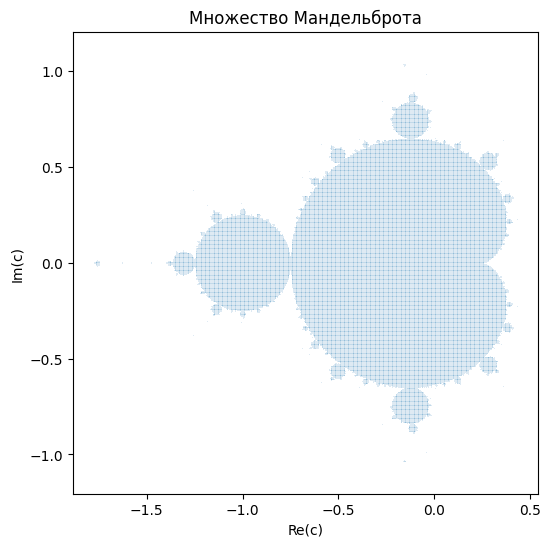

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("mandelbrot.csv", header=None, names=["x", "y"])

plt.figure(figsize=(6, 6))
plt.scatter(data["x"], data["y"], s=0.2, marker='.', linewidths=0)

plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.title("Множество Мандельброта 1 поток")
plt.axis("equal")
plt.show()

In [14]:
!./mandelbrot 2 500000

Time: 0.351344 seconds


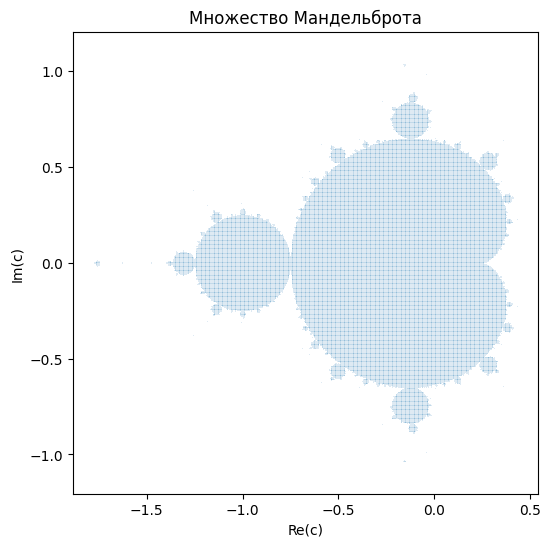

In [17]:
data = pd.read_csv("mandelbrot.csv", header=None, names=["x", "y"])

plt.figure(figsize=(6, 6))
plt.scatter(data["x"], data["y"], s=0.2, marker='.', linewidths=0)

plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.title("Множество Мандельброта 2 потока")
plt.axis("equal")
plt.show()

In [18]:
!./mandelbrot 4 500000

Time: 0.31686 seconds


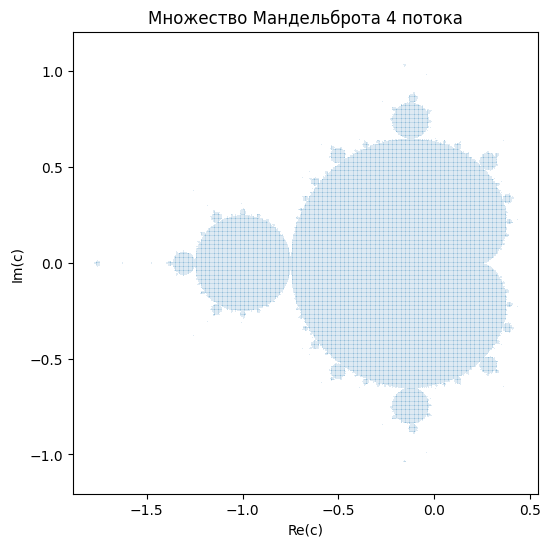

In [19]:
data = pd.read_csv("mandelbrot.csv", header=None, names=["x", "y"])

plt.figure(figsize=(6, 6))
plt.scatter(data["x"], data["y"], s=0.2, marker='.', linewidths=0)

plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.title("Множество Мандельброта 4 потока")
plt.axis("equal")
plt.show()

Таким образом, если мы берём 500000 точек и формулу расчёта ускорения (время выполнения на одном потоке/время выполнения на n потоках) результат следующий:
| Количество потоков | Время, с | Ускорение |
|-------------------|----------|-----------|
| 1 | 0.473 | 1.00 |
| 2 | 0.351 | 1.35 |
| 4 | 0.317 | 1.49 |

In [23]:
!./mandelbrot 1 1000000

Time: 0.951372 seconds


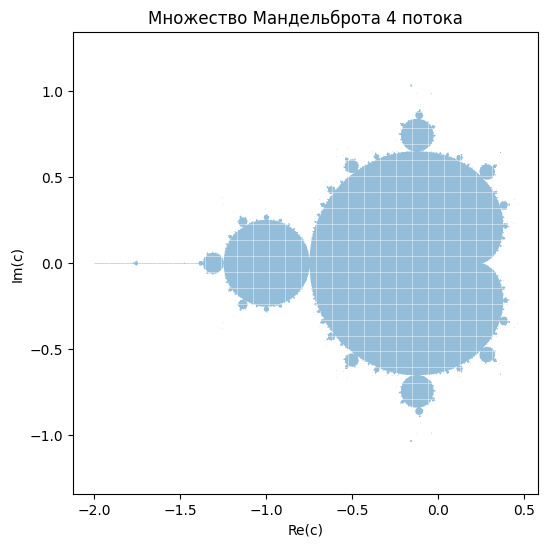

In [24]:
data = pd.read_csv("mandelbrot.csv", header=None, names=["x", "y"])

plt.figure(figsize=(6, 6))
plt.scatter(data["x"], data["y"], s=0.2, marker='.', linewidths=0)

plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.title("Множество Мандельброта 4 потока")
plt.axis("equal")
plt.show()

In [25]:
!./mandelbrot 2 1000000

Time: 0.707134 seconds


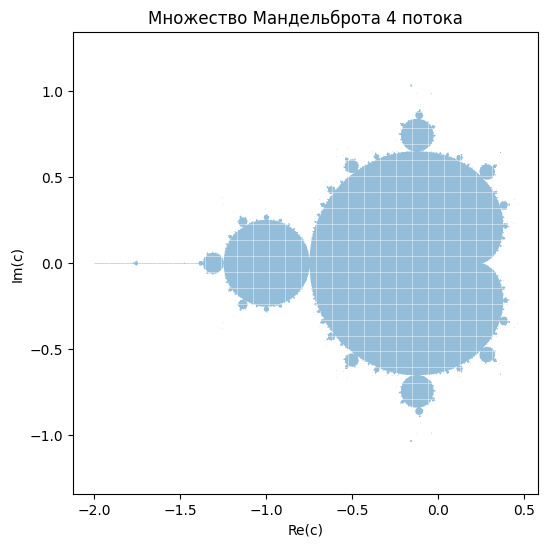

In [26]:
data = pd.read_csv("mandelbrot.csv", header=None, names=["x", "y"])

plt.figure(figsize=(6, 6))
plt.scatter(data["x"], data["y"], s=0.2, marker='.', linewidths=0)

plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.title("Множество Мандельброта 4 потока")
plt.axis("equal")
plt.show()

In [27]:
!./mandelbrot 4 1000000

Time: 0.651508 seconds


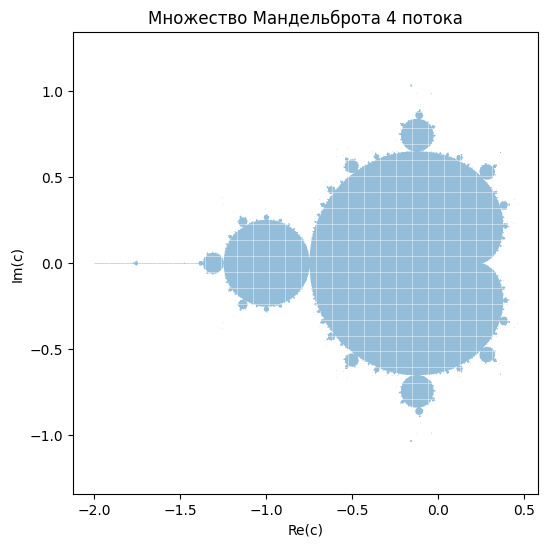

In [28]:
data = pd.read_csv("mandelbrot.csv", header=None, names=["x", "y"])

plt.figure(figsize=(6, 6))
plt.scatter(data["x"], data["y"], s=0.2, marker='.', linewidths=0)

plt.xlabel("Re(c)")
plt.ylabel("Im(c)")
plt.title("Множество Мандельброта 4 потока")
plt.axis("equal")
plt.show()

##Результаты для миллиона точек:
| Количество потоков | Время, с | Ускорение |
|-------------------|----------|-----------|
| 1 | 0.951 | 1.00 |
| 2 | 0.707 | 1.35 |
| 4 | 0.652 | 1.46 |

##Итого по ускорению
Учитывая, что ввод/ввывод в замеры не входит, мы получаем примерно следующую картину:
| Точек | Потоки | Время, с | Ускорение |
| ----- | ------ | -------- | --------- |
| 500k  | 1      | 0.473    | 1.00      |
| 500k  | 2      | 0.351    | 1.35      |
| 500k  | 4      | 0.317    | 1.49      |
| 1M    | 1      | 0.951    | 1.00      |
| 1M    | 2      | 0.707    | 1.35      |
| 1M    | 4      | 0.652    | 1.46      |

При увеличении объёма вычислений
ускорение остаётся стабильным, значит всё правильно. При увеличении числа точек наблюдается линейный рост времени выполнения,
что тоже подтверждает корректность реализации алгоритма. Отклонение от линейного ускорения можно объяснить накладными
расходами OpenMP, затратами на синхронизацию при объединении результатов
потоков, а также ограничениями вычислительной среды Google Colab.

#Вывод
В ходе выполнения лабораторной работы была реализована параллельная
программа для нахождения множества Мандельброта с использованием OpenMP.
Задача хорошо поддаётся распараллеливанию, так как вычисления для
отдельных точек не имеют зависимостей.

Реализованный подход обеспечивает корректность вычислений и устойчивое
ускорение при увеличении числа потоков, что подтверждается результатами
экспериментальных замеров.